`pip install reformer_pytorch`


### References

- Text classification with the torchtext library: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html
- reformer-pytorch: https://github.com/lucidrains/reformer-pytorch?tab=readme-ov-file
- IMDB dataset: http://ai.stanford.edu/~amaas/data/sentiment/


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from reformer_pytorch import ReformerLM
from sklearn.metrics import accuracy_score, f1_score
import tqdm as tqdm
import time

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

## Build the dataset

Use the IMDB dataset for sentiment analysis. The dataset is already available in the `torchtext` library.

- label = 0 means negative sentiment
- label = 1 means positive sentiment.


In [3]:
train_iter, test_iter = IMDB(split=("train", "test"))

labels = {}
for label, line in test_iter:
    # print(label, line)
    # break
    labels[label] = labels.get(label, 0) + 1
labels

{1: 12500, 2: 12500}

In [4]:
# Basic tokenizer for English
tokenizer = get_tokenizer("basic_english")


# Build vocabulary
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)


# Reload the training iterator for building vocab
train_iter, _ = IMDB(split=("train", "test"))
vocab = build_vocab_from_iterator(yield_tokens(
    train_iter), specials=["<unk>", "<pad>"])
vocab.set_default_index(
    vocab["<unk>"]
)  # Set default index for out-of-vocabulary tokens
NUM_TOKENS = len(vocab)

In [5]:
def text_pipeline(x):
    return vocab(tokenizer(x))


def label_pipeline(x):
    # the original dataset
    # 1 for negative, 2 for positive
    return x - 1


class IMDBDataset(Dataset):
    def __init__(self, split):
        self.examples = list()
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline
        self.avg_length = self.calculate_avg_length()
        # to avoid too long padding
        for label, text in IMDB(split=split):
            tokenized_text = tokenizer(text)
            if len(tokenized_text) <= self.avg_length:
                self.examples.append((label, text))

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        label, text = self.examples[idx]
        label = self.label_pipeline(label)
        text = torch.tensor(self.text_pipeline(text), dtype=torch.int64)
        return text, label

    def calculate_avg_length(self):
        lengths = [len(tokenizer(text)) for _, text in IMDB(split="train")]
        return sum(lengths) / len(lengths)


def collate_batch(batch):
    label_list, text_list = [], []
    max_len = 256  # Define the maximum sequence length

    for _text, _label in batch:
        label_list.append(_label)
        # Ensure _text is a tensor
        if len(_text) > max_len:
            # Truncate if longer than max_len
            _text = _text[:max_len]
        elif len(_text) < max_len:
            # Pad if shorter than max_len
            padding_length = max_len - len(_text)
            padding = torch.full(
                (padding_length,), vocab["<pad>"], dtype=torch.int64
            )  # Ensure vocab['<pad>'] is defined and consistent with your data
            _text = torch.cat((_text, padding), dim=0)

        text_list.append(_text)

    # Stack all texts and labels into tensors
    texts = torch.stack(text_list, dim=0)
    labels = torch.tensor(label_list, dtype=torch.int64)

    return texts, labels

In [6]:
# Create DataLoader
train_dataset = IMDBDataset("train")
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch
)
test_dataset = IMDBDataset("test")
test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch
)

In [7]:
for text, label in train_loader:
    print("Text batch shape:", text.size())
    # print(text)
    print("Label batch shape:", label.size())
    # print(label)
    break

Text batch shape: torch.Size([32, 256])
Label batch shape: torch.Size([32])


In [8]:
NUM_CLASSES = 2
NUM_ENCODER_LAYERS = 3
NUM_HEADS = 4
EMEBED_DIM = 256
TRAIN_EPOCHS = 6
seq_length = 256

## Transformer


In [9]:
class EncoderOnlyTransformer(nn.Module):
    def __init__(self, d_model=256, nhead=4, num_encoder_layers=1, dim_feedforward=256):
        super(EncoderOnlyTransformer, self).__init__()
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                batch_first=True,
            ),
            num_layers=num_encoder_layers,
        )
        self.dropout = nn.Dropout(0.2)
        self.embedding = nn.Embedding(NUM_TOKENS, d_model)
        self.classifier = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.embedding(src)
        encoded_output = self.transformer_encoder(src)
        # encoded_output = encoded_output[:, -1, :]
        encoded_output = self.dropout(encoded_output)
        encoded_output = encoded_output.max(dim=1)[0]
        output = self.classifier(encoded_output)
        return output


transformer_model = EncoderOnlyTransformer(
    d_model=EMEBED_DIM,
    nhead=NUM_HEADS,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    dim_feedforward=EMEBED_DIM,
).to(device)

In [10]:
total_trainable_params = sum(
    p.numel() for p in transformer_model.parameters() if p.requires_grad
)
print(f"{total_trainable_params:,} training parameters.\n")

26,962,689 training parameters.



### Train the Transformer model


In [11]:
# use cross entropy loss for classification task
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=0.00001)

In [12]:
def calculate_accuracy(output, y_true):
    y_pred = torch.sigmoid(output).round()
    return accuracy_score(y_true.detach().cpu().numpy(), y_pred.detach().cpu().numpy())

In [13]:
# Training Loop
transformer_model.train()
start_time = time.time()
transformer_train_loss = []
transformer_train_acc = []
current_step = 0
for epochs in tqdm.tqdm(range(TRAIN_EPOCHS)):
    for reviews, label in train_loader:
        reviews = reviews.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = transformer_model(reviews)
        output = output.squeeze()
        label = label.float()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        if current_step % 10 == 0:
            acc = calculate_accuracy(output, label)
            transformer_train_loss.append(loss.item())
            transformer_train_acc.append(acc)
            if current_step % 100 == 0:
                print(
                    f"""Step {current_step}: Loss {
                        loss.item()} Accuracy {acc}"""
                )
        current_step += 1

elapsed_time = time.time() - start_time
print("Training transformer completed.")
print(f"Training time: {elapsed_time:.2f} seconds")

  0%|          | 0/6 [00:00<?, ?it/s]

Step 0: Loss 0.76800936460495 Accuracy 0.34375
Step 100: Loss 0.6544814109802246 Accuracy 0.75
Step 200: Loss 0.6441060900688171 Accuracy 0.65625
Step 300: Loss 0.6706139445304871 Accuracy 0.53125
Step 400: Loss 0.6844937205314636 Accuracy 0.59375
Step 500: Loss 0.6601665019989014 Accuracy 0.625


 17%|█▋        | 1/6 [00:46<03:54, 46.88s/it]

Step 600: Loss 0.6455370187759399 Accuracy 0.625
Step 700: Loss 0.6144317388534546 Accuracy 0.6875
Step 800: Loss 0.6474875211715698 Accuracy 0.65625
Step 900: Loss 0.5639612674713135 Accuracy 0.84375
Step 1000: Loss 0.617080807685852 Accuracy 0.71875


 33%|███▎      | 2/6 [01:32<03:05, 46.33s/it]

Step 1100: Loss 0.6272757053375244 Accuracy 0.625
Step 1200: Loss 0.5458016395568848 Accuracy 0.78125
Step 1300: Loss 0.5593353509902954 Accuracy 0.75
Step 1400: Loss 0.499389111995697 Accuracy 0.90625
Step 1500: Loss 0.5780198574066162 Accuracy 0.78125


 50%|█████     | 3/6 [02:19<02:19, 46.35s/it]

Step 1600: Loss 0.5259666442871094 Accuracy 0.71875
Step 1700: Loss 0.4879053831100464 Accuracy 0.8125
Step 1800: Loss 0.501115083694458 Accuracy 0.875
Step 1900: Loss 0.47061026096343994 Accuracy 0.75
Step 2000: Loss 0.6498312950134277 Accuracy 0.59375


 67%|██████▋   | 4/6 [03:05<01:32, 46.43s/it]

Step 2100: Loss 0.47904568910598755 Accuracy 0.71875
Step 2200: Loss 0.37584495544433594 Accuracy 0.90625
Step 2300: Loss 0.587542712688446 Accuracy 0.6875
Step 2400: Loss 0.46991902589797974 Accuracy 0.84375
Step 2500: Loss 0.4867269992828369 Accuracy 0.84375


 83%|████████▎ | 5/6 [03:52<00:46, 46.46s/it]

Step 2600: Loss 0.531295895576477 Accuracy 0.8125
Step 2700: Loss 0.418088436126709 Accuracy 0.84375
Step 2800: Loss 0.47714537382125854 Accuracy 0.75
Step 2900: Loss 0.43789634108543396 Accuracy 0.8125
Step 3000: Loss 0.4189438819885254 Accuracy 0.84375
Step 3100: Loss 0.5126327872276306 Accuracy 0.71875


100%|██████████| 6/6 [04:38<00:00, 46.48s/it]

Training transformer completed.
Training time: 278.91 seconds


### Evaluate the Transformer model


In [14]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode

    true_labels = []
    predictions = []

    with torch.no_grad():  # No need to track gradients
        for texts, labels in dataloader:
            texts = texts.to(device)
            labels = labels.to(device)

            outputs = model(texts)
            outputs = outputs.squeeze()

            probs = torch.sigmoid(outputs)
            predicted_labels = probs.round()
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted_labels.cpu().numpy())

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average="binary")

    return accuracy, f1

In [15]:
transformer_accuracy, transformer_f1 = evaluate_model(
    model=transformer_model, dataloader=test_loader, device=device
)

In [16]:
transformer_accuracy, transformer_f1

(0.788368526601392, 0.7729975958496773)

In [24]:
import gc

# Clean up the memory
del transformer_model
# Clear GPU cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
gc.collect()  # Explicit garbage collection

NameError: name 'transformer_model' is not defined

## Build the Reformer


In [30]:
class ReformerForClassification(nn.Module):
    def __init__(self, num_tokens, emb_dim, dim, depth, heads, max_seq_len):
        super(ReformerForClassification, self).__init__()
        self.encoder = ReformerLM(
            num_tokens=num_tokens,
            emb_dim=emb_dim,
            dim=dim,
            depth=depth,
            heads=heads,
            max_seq_len=max_seq_len,
            fixed_position_emb=True,
            return_embeddings=True,
        )

        # Classification head
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(dim, 1)

    def forward(self, x):
        # Encoder processes the input
        encoded_output = self.encoder(x)
        encoded_output = self.dropout(encoded_output)
        encoded_output = encoded_output.max(dim=1)[0]
        output = self.classifier(encoded_output)

        return output

### Train the Reformer model


In [31]:
reformer = ReformerForClassification(
    num_tokens=NUM_TOKENS,
    emb_dim=EMEBED_DIM,
    dim=EMEBED_DIM,
    depth=NUM_ENCODER_LAYERS,
    heads=NUM_HEADS,
    max_seq_len=seq_length,
).to(device)

In [32]:
total_trainable_params = sum(
    p.numel() for p in reformer.parameters() if p.requires_grad
)
print(f"{total_trainable_params:,} training parameters.\n")

27,946,241 training parameters.



In [33]:
optimizer = optim.Adam(reformer.parameters(), lr=0.00001)
reformer_train_loss = []
reformer_train_acc = []
# for current_step in tqdm.tqdm(range(total_steps)):
current_step = 0
start_time = time.time()
for epochs in tqdm.tqdm(range(TRAIN_EPOCHS)):
    for reviews, label in train_loader:
        reviews = reviews.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = reformer(reviews)
        output = output.squeeze()
        # print(output.size(), label.size())
        label = label.float()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        current_step += 1
        if current_step % 10 == 0:
            acc = calculate_accuracy(output, label)
            reformer_train_loss.append(loss.item())
            reformer_train_loss.append(acc)
            if current_step % 100 == 0:
                print(
                    f"""Step {current_step}: Loss {
                        loss.item()} Accuracy {acc}"""
                )

elapsed_time = time.time() - start_time
print("Training Reformer completed.")
print(f"Training time: {elapsed_time:.2f} seconds")

  0%|          | 0/6 [00:00<?, ?it/s]

Step 100: Loss 0.7204930782318115 Accuracy 0.5
Step 200: Loss 0.7280282378196716 Accuracy 0.40625
Step 300: Loss 0.65981525182724 Accuracy 0.625
Step 400: Loss 0.6636711359024048 Accuracy 0.5625
Step 500: Loss 0.6133213639259338 Accuracy 0.71875


 17%|█▋        | 1/6 [04:44<23:44, 284.96s/it]

Step 600: Loss 0.6724161505699158 Accuracy 0.5
Step 700: Loss 0.628038227558136 Accuracy 0.71875
Step 800: Loss 0.6241970658302307 Accuracy 0.6875
Step 900: Loss 0.632611870765686 Accuracy 0.625
Step 1000: Loss 0.672920823097229 Accuracy 0.625


 33%|███▎      | 2/6 [09:27<18:54, 283.60s/it]

Step 1100: Loss 0.6552684307098389 Accuracy 0.625
Step 1200: Loss 0.6383309960365295 Accuracy 0.5625
Step 1300: Loss 0.5774133205413818 Accuracy 0.8125
Step 1400: Loss 0.6062222719192505 Accuracy 0.71875
Step 1500: Loss 0.5626308917999268 Accuracy 0.75


 50%|█████     | 3/6 [14:14<14:15, 285.23s/it]

Step 1600: Loss 0.6434519290924072 Accuracy 0.53125
Step 1700: Loss 0.5355865955352783 Accuracy 0.84375
Step 1800: Loss 0.555018424987793 Accuracy 0.75
Step 1900: Loss 0.6188451647758484 Accuracy 0.71875
Step 2000: Loss 0.5944840908050537 Accuracy 0.78125


 67%|██████▋   | 4/6 [18:58<09:29, 284.54s/it]

Step 2100: Loss 0.46560904383659363 Accuracy 0.90625
Step 2200: Loss 0.49937018752098083 Accuracy 0.84375
Step 2300: Loss 0.6512545347213745 Accuracy 0.625
Step 2400: Loss 0.436227947473526 Accuracy 0.90625
Step 2500: Loss 0.50152587890625 Accuracy 0.75


 83%|████████▎ | 5/6 [23:38<04:43, 283.16s/it]

Step 2600: Loss 0.48756951093673706 Accuracy 1.0
Step 2700: Loss 0.48813140392303467 Accuracy 0.84375
Step 2800: Loss 0.5157549381256104 Accuracy 0.71875
Step 2900: Loss 0.48087331652641296 Accuracy 0.78125
Step 3000: Loss 0.5524560809135437 Accuracy 0.6875
Step 3100: Loss 0.4902305603027344 Accuracy 0.71875


100%|██████████| 6/6 [28:24<00:00, 284.04s/it]

Training Reformer completed.
Training time: 1704.23 seconds


### Evaluate the Reformer model


In [34]:
reformer_accuracy, reformer_f1 = evaluate_model(
    model=reformer, dataloader=test_loader, device=device
)

In [35]:
reformer_accuracy, reformer_f1

(0.7807597027250206, 0.7870036101083033)

## Plot the results


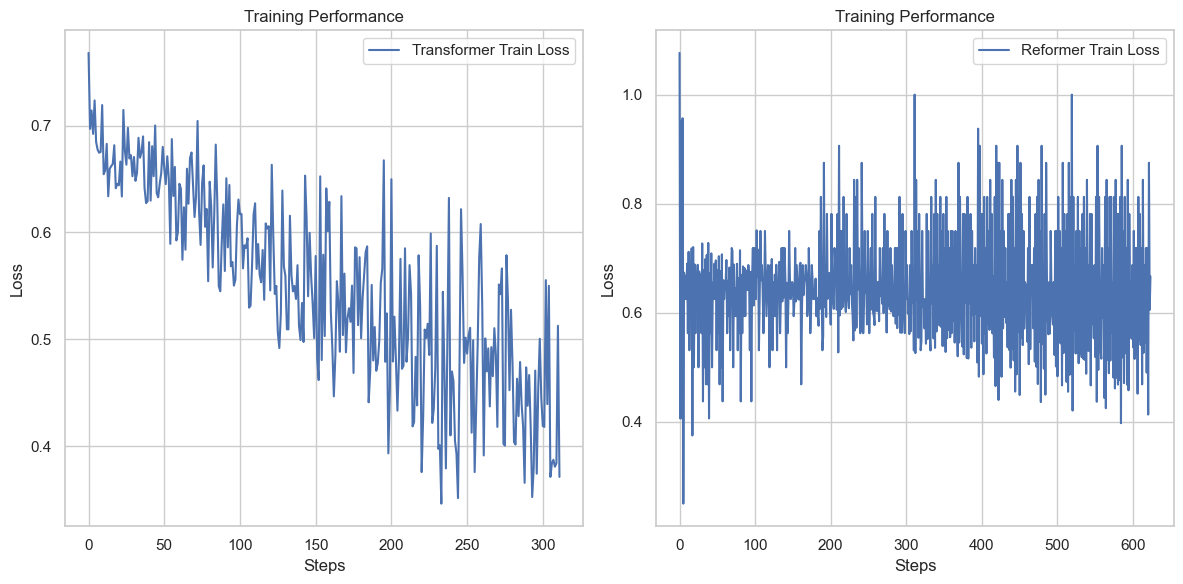

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Plot settings
sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# Plotting training data
sns.lineplot(
    ax=ax[0],
    data={
        "Transformer Train Loss": transformer_train_loss,
    },
    dashes=False,
)
ax[0].set_title("Training Performance")
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Loss")
ax[0].legend(loc="upper right")

sns.lineplot(
    ax=ax[1],
    data={
        "Reformer Train Loss": reformer_train_loss,
    },
    dashes=False,
)
ax[1].set_title("Training Performance")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Loss")
ax[1].legend(loc="upper right")

plt.tight_layout()
plt.show()